# Fundamentals of Machine Learning - Exercise 5
Dominique Cheray & Manuel Krämer
## 1 Constructing the matrix X

In [1]:
import numpy as np
from scipy.sparse import linalg
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

In [2]:
def construct_X(M, alphas, Np=None):
    if not Np:
        Np = np.ceil(np.sqrt(2) * M).astype(int)
    if Np % 2 == 0:
        Np += 1
    D = M * M
    No = len(alphas)
    N = Np * No
    C1 = (np.mgrid[0:M, 0:M][0]).flatten()
    C2 = (np.mgrid[0:M, 0:M][1]).flatten()
    C = np.vstack((C1, C2))
    # centralise the coordinates in C
    C = C - (M - 1) / 2
    # convert alphas to radian
    alphas_rad = np.radians(alphas)
    # now make vectors out of the angles
    n = np.zeros((2, No))
    n[0] = -np.sin(alphas_rad)
    n[1] = np.cos(alphas_rad)
    p = n.T.dot(C) + (Np - 1) / 2
    lower_element = np.floor(p).astype(int)
    upper_element = np.ceil(p).astype(int)
    lower_value = upper_element - p
    upper_value = p - lower_element
    weights = []
    i_indices = []
    j_indices = []
    for i in range(No):
        for j in range(len(lower_element[i])):
            if (lower_element[i][j] == upper_element[i][j]):
                weights.append(1)
                i_indices.append(i*Np+lower_element[i][j])
                j_indices.append(j)
            else:
                weights.append(lower_value[i][j])
                i_indices.append((i*Np+lower_element[i][j]))
                j_indices.append(j)
                weights.append(upper_value[i][j])
                i_indices.append(((i*Np+upper_element[i][j])))
                j_indices.append(j)
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
#    print('Matrix is ready')
    return X

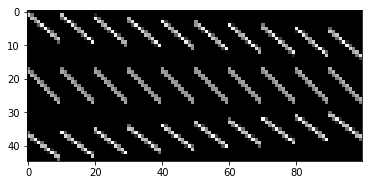

In [3]:
X_testing = construct_X(10, [-33, 1, 42])

X_dense = X_testing.todense()
plt.imshow(X_dense, interpolation="nearest", cmap=plt.cm.Greys_r)
plt.show()

##  2 Recovering the image

Number of non-zero elements: 13535957
Sparsity: 0.992768406286928


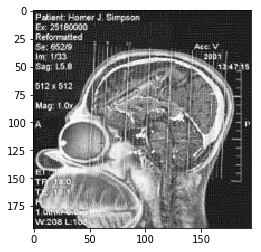

In [4]:
alphas195 = np.load('hs_tomography/alphas_195.npy')
X = construct_X(195, alphas195, 275)
print('Number of non-zero elements: ' + str(X.nnz))
total_elements = X.shape[0] * X.shape[1]
zeros = total_elements - X.nnz
sparsity = zeros/total_elements
print('Sparsity: ' + str(sparsity))
X_csc = X.tocsc()
y = np.load('hs_tomography/y_195.npy')
img = linalg.lsqr(X_csc, y, atol=1e-05, btol=1e-05)
img = img[0]
img = img.reshape((195, 195))
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.show()

Diagnosis: He has a crayon in his brain.
Proposed Treatment: Melt the crayon and then withdraw the molten wax by suction. Make a candle out of the wax as a souvenir.

## 3 Minimizing the radiation dose

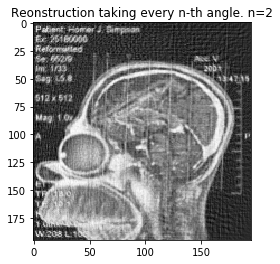

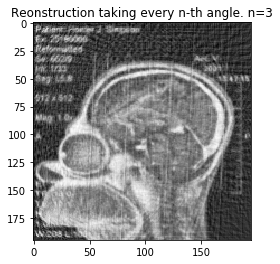

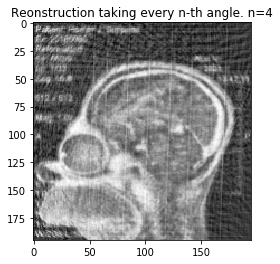

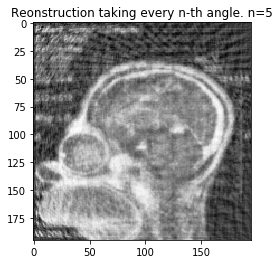

In [5]:
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')
Np = 275
length = len(alphas)
stepsizes = [2, 3, 4, 5]
for j in range(len(stepsizes)):
    step = stepsizes[j]
    newalphas = []
    newy = np.array([])
    for i in range(0, length, step):
        newalphas.append(alphas[i])
        data = y[np.arange(i*Np, i*Np+Np)]
        newy = np.concatenate((newy, data))
    reduced_X = construct_X(195, newalphas, 275)
    reduced_X_csc = reduced_X.tocsc()
    img = linalg.lsqr(reduced_X_csc, newy, atol=1e-05, btol=1e-05)
    img = img[0]
    img = img.reshape((195, 195))
    #plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.title("Reonstruction taking every n-th angle. n=" +str(step))
    plt.show()


Taking every 5th angle of the original dataset one can see the head, but not really what causes the headache. Taking every 4th angle one starts to see that there ist a foreign object inside the brain of the patient. Taking every 3rd angle and being a good radiologist makes it possible to identify the object as a crayon. A bad radiologist might need the reconstruction taking every second angle. So to determine that the headache is caused by a foreign object in the patient's brain one needs at least 44 projections. To determine the nature of the foreign object one needs at least 59 projections and a good radiologist. If you don't have a good radiologist at hand the minimum number of projections lies inbetween 59 and 89.